## 라이브러리

In [1]:
import re
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from collections import Counter
import sentencepiece as spm
from kiwipiepy import Kiwi  
from konlpy.tag import Okt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader  
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import random
import nltk
from nltk.translate.bleu_score import sentence_bleu
import os
from collections import Counter
from torchtext.vocab import vocab
from torch.nn.utils.rnn import pad_sequence
import torchtext
import seaborn as sns
from torchtext.vocab import Vocab
from collections import OrderedDict
from torchtext.vocab import build_vocab_from_iterator


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


## 데이터 불러오기

In [3]:
# 데이터 파일 경로 설정
data_dir = Path("/Users/jian_lee/Desktop/aiffel/data/s2s_translation")

train_ko_path = data_dir / "korean-english-park.train/korean-english-park.train.ko"
train_en_path = data_dir / "korean-english-park.train/korean-english-park.train.en"

test_ko_path = data_dir / "korean-english-park.test/korean-english-park.test.ko"
test_en_path = data_dir / "korean-english-park.test/korean-english-park.test.en"

dev_ko_path = data_dir / "korean-english-park.dev/korean-english-park.dev.ko"
dev_en_path = data_dir / "korean-english-park.dev/korean-english-park.dev.en"

In [4]:
# 한-영 병렬 데이터 로드 함수
def load_data(ko_path, en_path):
    """파일에서 한-영 병렬 데이터를 불러옵니다."""
    with open(ko_path, "r", encoding="utf-8") as f:
        kor_lines = f.readlines()
    with open(en_path, "r", encoding="utf-8") as f:
        eng_lines = f.readlines()
    
    return [k.strip() for k in kor_lines], [e.strip() for e in eng_lines]

# 데이터 로드
kor_sentences, eng_sentences = load_data(train_ko_path, train_en_path)

# 데이터 개수 확인
print(f"Korean Sentences Count: {len(kor_sentences)}")
print(f"English Sentences Count: {len(eng_sentences)}")

Korean Sentences Count: 94123
English Sentences Count: 94123


## 텍스트 정제

In [5]:
# Kiwi 형태소 분석기 초기화
kiwi = Kiwi()

# 텍스트 정제 함수
def clean_text(text, lang="ko", correct_spacing=False):
    """한글과 영어에 맞는 정규 표현식을 사용하여 텍스트 정제"""
    text = text.lower().strip()  # 대소문자 변환 및 공백 제거

    if lang == "ko":
        text = re.sub(r"[^\uAC00-\uD7A3a-zA-Z0-9.,!?\s]", "", text)  # 한글, 영어, 숫자, 기본 구두점만 허용
        text = re.sub(r"\s+", " ", text)  # 다중 공백 제거
        if correct_spacing:
            text = kiwi.space(text)  # 띄어쓰기 보정 (kiwipiepy 활용)
    else:
        text = re.sub(r"[^a-zA-Z0-9.,!?\s]", "", text)  # 영어, 숫자, 기본 구두점만 허용
        text = re.sub(r"\s+", " ", text)  # 다중 공백 제거

    return text.strip()

# 데이터 정제 및 중복 제거
def preprocess_data(kor_sentences, eng_sentences, correct_spacing=True):
    """중복을 제거하고 전처리를 수행 (대소문자 변환, 공백 정리, 띄어쓰기 보정 포함)"""
    paired_data = set(zip(kor_sentences, eng_sentences))  # 중복 제거
    cleaned_corpus = [(clean_text(k, "ko", correct_spacing), clean_text(e, "en")) for k, e in paired_data]
    return cleaned_corpus

cleaned_corpus = preprocess_data(kor_sentences, eng_sentences)

# 데이터 개수 확인
print(f"Filtered Sentences: {len(cleaned_corpus)}")

Filtered Sentences: 78941


## 토큰화 및 단어 사전 생성

In [6]:
def yield_tokens(corpus):
    for sentence in corpus:
        yield sentence.split()

def build_vocab(corpus, vocab_size=20000, min_freq=1):
    """
    PyTorch 기반의 Vocab 생성 함수 (torchtext 최신 버전 대응)
    - corpus: 토큰화된 문장 리스트
    - vocab_size: 단어 집합 크기
    - min_freq: 최소 등장 빈도 (이 값보다 적게 등장하는 단어는 제외)
    """
    specials = ["<pad>", "<unk>", "<start>", "<end>"]
    # build_vocab_from_iterator를 사용하여 단어 사전 생성
    vocab = build_vocab_from_iterator(
        yield_tokens(corpus),
        specials=specials,
        max_tokens=vocab_size,
        min_freq=min_freq
    )
    # <unk> 토큰의 인덱스를 기본값으로 설정
    vocab.set_default_index(vocab["<unk>"])
    
    return vocab

# 단어 사전 생성
kor_vocab = build_vocab(kor_sentences, vocab_size=10000, min_freq=1)
eng_vocab = build_vocab(eng_sentences, vocab_size=10000, min_freq=1)

# 단어 사전 크기 확인
print(f"Korean Vocab Size: {len(kor_vocab)}")
print(f"English Vocab Size: {len(eng_vocab)}")

# 단어 ID 확인
print(f"Index of '<pad>': {kor_vocab['<pad>']}")
print(f"Index of '<unk>': {kor_vocab['<unk>']}")
print(f"Index of '<start>': {kor_vocab['<start>']}")
print(f"Index of '<end>': {kor_vocab['<end>']}")

Korean Vocab Size: 10000
English Vocab Size: 10000
Index of '<pad>': 0
Index of '<unk>': 1
Index of '<start>': 2
Index of '<end>': 3


##  토큰화된 데이터를 PyTorch 텐서로 변환 및 패딩 적용

In [7]:
# 토큰화 및 패딩 적용 함수
def tokenize_and_pad(corpus, vocab_obj, max_len=40):
    sequences = [
        [vocab_obj["<start>"]] +
        [vocab_obj[word] if word in vocab_obj else vocab_obj["<unk>"] for word in sentence.split()] +
        [vocab_obj["<end>"]]
        for sentence in corpus
    ]

    sequences = [torch.tensor(seq[:max_len], dtype=torch.long) for seq in sequences]
    sequences = pad_sequence(sequences, batch_first=True, padding_value=vocab_obj["<pad>"])

    return sequences

# 토큰화 및 패딩 적용
kor_tensor = tokenize_and_pad(kor_sentences, kor_vocab, max_len=40)
eng_tensor = tokenize_and_pad(eng_sentences, eng_vocab, max_len=40)

# 데이터 형태 출력
print(f"Korean Tensor Shape: {kor_tensor.shape}")
print(f"English Tensor Shape: {eng_tensor.shape}")

Korean Tensor Shape: torch.Size([94123, 40])
English Tensor Shape: torch.Size([94123, 40])


##  전처리된 데이터 랜덤 샘플 확인

In [8]:
def show_random_samples(kor_corpus, eng_corpus, num_samples=5):
    indices = random.sample(range(len(kor_corpus)), min(num_samples, len(kor_corpus)))

    print("\n🔹 전처리된 데이터 샘플 확인 (랜덤 선택) 🔹\n")
    for i, idx in enumerate(indices):
        print(f"Sample {i+1}")
        print(f" Tokenized Korean: {kor_corpus[idx]}")
        print(f" Tokenized English: {eng_corpus[idx]}")
        print("-" * 50)

# 전처리된 샘플 데이터 확인
show_random_samples(kor_sentences, eng_sentences, num_samples=5)


🔹 전처리된 데이터 샘플 확인 (랜덤 선택) 🔹

Sample 1
 Tokenized Korean: 오랫동안 후세인 대통령에 반기를 들었던 한 보수 시아파 그룹으로 이란에 본부를 둔 이라크 이슬람 혁명 최고 위원회 런던 대표인 하미드 알-바야티씨는 이라크가 그런 과거에도 불구하고 결국에는 자기가 세계적인 추세라고 여기는 쪽으로 가게 될 것이라고 믿고있다.
 Tokenized English: Hamid al-Bayati, London representative of the Iran-based Supreme Council for the Islamic Revolution in Iraq, a conservative Shiite group long opposed to Saddam, believes that despite its past, Iraq will eventually fall in line with what he sees as a global trend.
--------------------------------------------------
Sample 2
 Tokenized Korean: 중국의 위안화 평가절상으로 인해 원화가치가 5개월 만에 급상승했지만 한국 수출주는 가격경쟁력 상실에 대한 우려로 하락세를 보였다.
 Tokenized English: China's currency revaluation propelled the won to its biggest advance in five months yesterday but Korean exporters fell on the stock market on fears they will lose their price competitiveness.
--------------------------------------------------
Sample 3
 Tokenized Korean: 경찰 고위 간부인 수리아 다르마 국장은 두자니에 대해 “매우 위험하면서도 영리한 인물”이라고 설명했다.
 Tokenized E

## 모델 설계

In [9]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout_rate=0.3):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        output, hidden = self.gru(embedded)
        return output, hidden


class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.W_enc = nn.Linear(hidden_size, hidden_size)
        self.W_dec = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)

    def forward(self, h_enc, h_dec):
        h_dec = h_dec.unsqueeze(1)  # (batch, 1, hidden_size)
        score = self.V(torch.tanh(self.W_dec(h_dec) + self.W_enc(h_enc))).squeeze(2)
        attn_weights = F.softmax(score, dim=1)
        context_vector = torch.sum(attn_weights.unsqueeze(2) * h_enc, dim=1)
        return context_vector, attn_weights


class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, dropout_rate=0.3):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(hidden_size + embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.attention = BahdanauAttention(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, hidden, enc_out):
        context_vector, attn_weights = self.attention(enc_out, hidden[-1])
        x = self.dropout(self.embedding(x))
        x = torch.cat([context_vector.unsqueeze(1), x], dim=-1)
        output, hidden = self.gru(x, hidden)
        output = self.fc(output.squeeze(1))
        return output, hidden, attn_weights


# ✅ 하이퍼파라미터 설정
embedding_dim = 512
hidden_size = 1024
vocab_size = 10000  # 단어 사전 크기 (임의 설정)
batch_size = 64
num_epochs = 10

# ✅ 모델 초기화 (Apple Silicon GPU로 이동)
encoder = Encoder(vocab_size, embedding_dim, hidden_size).to(device)
decoder = Decoder(vocab_size, embedding_dim, hidden_size).to(device)

# ✅ Optimizer & Loss 설정
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # 패딩 토큰 무시

## 모델 학습 & 시각화

In [14]:
# Mac GPU (MPS) 활성화
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f" Using device: {device}")

def train_step(src, tgt, encoder, decoder, optimizer, criterion, teacher_forcing_ratio=0.5):
    """
    PyTorch 기반 학습 단계 (한 배치 학습)
    - teacher forcing을 적용하여 일정 확률로 실제 정답을 디코더 입력으로 사용
    """
    optimizer.zero_grad()
    src, tgt = src.to(device), tgt.to(device)
    
    enc_out, enc_hidden = encoder(src)
    dec_hidden = enc_hidden

    # '<start>' 토큰 인덱스 가져오기
    start_token_idx = eng_vocab.get_stoi()["<start>"]
    dec_input = torch.full((tgt.shape[0], 1), start_token_idx, dtype=torch.long).to(device)

    loss = 0
    use_teacher_forcing = random.random() < teacher_forcing_ratio

    for t in range(1, tgt.shape[1]):
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_out)
        
        loss += criterion(predictions, tgt[:, t])

        # Teacher Forcing 여부에 따라 다음 입력 결정
        if use_teacher_forcing:
            dec_input = tgt[:, t].unsqueeze(1)  # 실제 정답을 다음 입력으로
        else:
            dec_input = predictions.argmax(dim=1, keepdim=True)  # 예측값을 다음 입력으로

    loss.backward()

    # ✅ MPS에서는 clip_grad_norm_이 NaN을 유발할 수 있어 조정 필요
    torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(decoder.parameters()), max_norm=1)

    optimizer.step()

    return loss.item() / tgt.shape[1]

 Using device: mps


In [15]:
# 배치 크기 설정
BATCH_SIZE = 64  
EPOCHS = 10  # 학습 반복 횟수
train_losses = []  # 학습 과정에서 Loss를 저장할 리스트

# Training Loop
for epoch in range(EPOCHS):
    total_loss = 0
    idx_list = list(range(0, kor_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for batch, idx in enumerate(t):
        # ✅ MPS에서는 to("mps")로 GPU 이동 필요
        batch_loss = train_step(
            torch.tensor(kor_tensor[idx:idx + BATCH_SIZE], dtype=torch.long).to(device),
            torch.tensor(eng_tensor[idx:idx + BATCH_SIZE], dtype=torch.long).to(device),
            encoder.to(device), decoder.to(device), optimizer, criterion
        )
        total_loss += batch_loss

        t.set_description_str(f'Epoch {epoch + 1}')
        t.set_postfix_str(f'Loss {total_loss / (batch + 1):.4f}')
    
    # Epoch마다 평균 Loss 저장
    train_losses.append(total_loss / (batch + 1))

# 학습 완료 후 train_losses 저장
print("\n✅ Training Completed!")

  0%|          | 0/1471 [00:00<?, ?it/s]/var/folders/hc/bq30j1bj47s2zv8mz3y8yh040000gn/T/ipykernel_32692/823388512.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(kor_tensor[idx:idx + BATCH_SIZE], dtype=torch.long).to(device),
/var/folders/hc/bq30j1bj47s2zv8mz3y8yh040000gn/T/ipykernel_32692/823388512.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(eng_tensor[idx:idx + BATCH_SIZE], dtype=torch.long).to(device),
Epoch 10: 100%|██████████| 1471/1471 [15:12<00:00,  1.61it/s, Loss 3.9019]


✅ Training Completed!


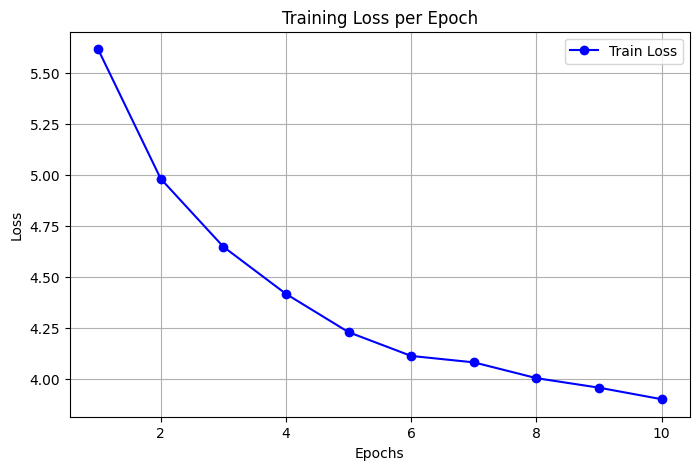

In [16]:
def plot_train_loss(train_losses):
    """
    Train Loss를 시각화하는 함수
    """
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-', color='b', label='Train Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

# ✅ Loss 시각화 실행 (훈련 완료 후 실행)
plot_train_loss(train_losses)

---

## 회고

- 학습 후 테스트 및 히트맵을 그려보지 못한게 아쉬움으로 남습니다.

- 모델 학습이 되었으나 loss 값이 높은 걸 확인했습니다. 원인을 좀 더 찾아보고자 합니다.

- 데이터 전처리를 조금 더 다양한 방법을 활용해 반영해보고자 합니다.